In [15]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc
import scipy.integrate as integrate

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/'
source = source_dir+'aqua_2m/'
            
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/")
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/")

fig_dest="/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/"

a=6371.0e3
R=a

In [4]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

NC=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.nc'))

In [5]:
m5_nc=nc.Dataset(NC[2],'r'); 
m10_nc=nc.Dataset(NC[3],'r'); 
m50_nc=nc.Dataset(NC[1],'r'); 
m100_nc=nc.Dataset(NC[0],'r');
keys=m5_nc.variables.keys()
# print keys

In [6]:
longname=[0,0,0]

for i in range(0,len(keys)):
    if ( (i!=2) and (i!=15) and (i!=14) and (i!=16) ) :
#         longname=np.append(longname, m5_nc.variables[keys[i]].long_name)
        print i,'. ',keys[i], '--' ,m5_nc.variables[keys[i]].long_name

0 .  lon -- longitude
1 .  lat -- latitude
3 .  tradl -- thermal radiation 200mb
4 .  sradl -- solar radiation 200mb
5 .  trafl -- thermal radiation 200mb (clear sky)
6 .  srafl -- solar radiation 200mb (clear sky)
7 .  trfliac -- LW flux over ice
8 .  trflwac -- LW flux over water
9 .  trfllac -- LW flux over land
10 .  sofliac -- SW flux over ice
11 .  soflwac -- SW flux over water
12 .  sofllac -- SW flux over land
13 .  friac -- ice cover (fraction of grid box)
17 .  tsw -- surface temperature of water
18 .  ustri -- zonal      wind stress over ice
19 .  vstri -- meridional wind stress over ice
20 .  ustrw -- zonal      wind stress over water
21 .  vstrw -- meridional wind stress over water
22 .  ustrl -- zonal      wind stress over land
23 .  vstrl -- meridional wind stress over land
24 .  ahfliac -- latent heat flux over ice
25 .  ahflwac -- latent heat flux over water
26 .  ahfllac -- latent heat flux over land
27 .  evapiac -- evaporation over ice
28 .  evapwac -- evaporation o

In [16]:
def RAD(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    SW_sfc= R(X['srads'][...]) # net surface solar radiation ---- downwards
    SW_toa= R(X['srad0'][...]) # net top solar radiation     ---- downwards
    olr   = R(X['trad0'][...])    # top thermal radiation (OLR) --- upwards
    LW_sfc= R(X['trads'][...]) # net surface thermal radiation  --- upwards
    shflx = R(X['ahfs'][...])    # ahfs -- sensible heat flux    --- upwards
    lhflx = R(X['ahfl'][...])    # ahfl -- latent heat flux      --- upwards
        
#     SW_toa_dn= R(X['srad0d'][...]) # top incoming solar radiation -- downward
#     SW_toa_up= R(X['srad0u'][...]) # top outgoing solar radiation -- upward
#     SW_sfc_up= R(X['sradsu'][...]) # surface solar radiation upward -- upward
    
#     SW_toa1=SW_toa_dn-SW_toa_up
    
#     LW_sfc_up= R(X['tradsu'][...]) # tradsu -- surface thermal radiation upward
#     olr      = R(X['trad0'][...])    # top thermal radiation (OLR) --- upwards -- top thermal radiation (OLR)
                      
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx #, SW_toa1   

In [17]:
SW_sfc=np.zeros((4,96,12)); SW_toa=np.copy(SW_sfc); 
LW_sfc=np.copy(SW_sfc); shflx=np.copy(SW_sfc); 
lhflx=np.copy(SW_sfc); olr=np.copy(SW_sfc); SW_toa1=np.copy(SW_sfc)

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc[i,...], SW_toa[i,...], olr[i,...], LW_sfc[i,...], shflx[i,...], lhflx[i,...]  = RAD(X[i])

lat=m5_nc['lat'][:]

In [18]:
# TOA= +SW_toa1 + olr                   ## downwards
# SFC= shflx + lhflx + LW_sfc - SW_sfc   ## upwards
# Net_rad=SFC+TOA

SWABS= +SW_toa - SW_sfc
SHF  = -(shflx + lhflx + LW_sfc)
Net_rad2= SWABS + SHF + olr

In [19]:
def interp_rad(rad,N=1):
  D = np.zeros((4,12))
  for m in range(0,12):
       for d in range(0,4) :
            latr=lat[1:-1]
            if N==1 :
              l_range=((latr>=30) & (latr<=70)) 
              X=storm_pos_N
            else    :
              l_range=((latr>=-70) & (latr<=-30))  
              X=storm_pos_S
            interpolation_function = interp1d(latr[l_range],rad[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [20]:
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1])#int_x[::-1][1:]+/2.0
    return avg_int_r/10**15

In [21]:
Iswabs=np.zeros((4,len(lat[1:-1]),12))
Ishf=np.copy(Iswabs); Ine=np.copy(Iswabs); Iolr=np.copy(Iswabs);Idhdt=np.copy(Iswabs)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    Iswabs[d,...]=interad(A(SWABS[d,...]))
    Ishf[d,...]  =interad(A(SHF[d,...]))
#   Ine[d,...]   =interad(Net_rad2[d,...]-Net_rad2[d,:,:].mean(axis=0)[None,:])
    Iolr[d,...]  =interad(A(olr[d,...]))
    #Idhdt[d,...] =interad(A(dhdt[d,...])) 
Ine=Iswabs+Ishf+Iolr#-Idhdt


In [22]:
def zon_int(x):
    y=x#*2*np.pi*np.cos(np.deg2rad(lat[:,None]))*a
    return y/10**15

import scipy.integrate as integrate
def integrated(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*( int_x_r)#[::-1,:][1:,:] )/1 #
    return avg_int_r/10**15

In [23]:
MAT=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.mat'))

In [24]:
m5  =sio.loadmat(MAT[0]); 
m10 =sio.loadmat(MAT[2]); 
m50 =sio.loadmat(MAT[1]); 
m100=sio.loadmat(MAT[3]);

In [11]:
def MSE(X):
    MM= (X['mean_cpt_monthly'] +X['mean_gz_monthly'] +X['mean_Lq_monthly']).mean(axis=1)
    SE= (X['seddy_cpt_monthly']+X['seddy_gz_monthly']+X['seddy_Lq_monthly']).mean(axis=1)
    TE= (X['teddy_cpt_monthly']+X['teddy_gz_monthly']+X['teddy_Lq_monthly']).mean(axis=1)
    return zon_int(MM), zon_int(SE), zon_int(TE)    ## Actually it is already 

In [12]:
MM=np.zeros((4,96,12)); SE=np.copy(MM); TE=np.copy(MM)

In [13]:
X=[m5, m10, m50, m100]
for i in range(4) :
    MM[i,...], SE[i,...], TE[i,...] = MSE(X[i])

In [14]:
dtheta=np.radians(lat[1]-lat[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for m in range(12):
           div[:,m]= smooth( np.gradient((x[:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat[:])) ),N)
       return div

div_TE=np.copy(TE); div_SE=np.copy(SE); div_MM=np.copy(MM);
 
for d in range(4):
    div_TE[d,...]=spher_div(TE[d,...]*10**15)
    div_SE[d,...]=spher_div(SE[d,...]*10**15)
    div_MM[d,...]=spher_div(MM[d,...]*10**15)
div_NE=div_TE+div_SE+div_MM

In [15]:
from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
         l_range=((lat>=30) & (lat<=60))            
        else    :
         l_range=((lat>=-60) & (lat<=-30))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan

        
  return zero_loc

storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
for d in range(4):
    storm_pos_N[d,:]=find_zero(div_TE[d,...],+1)
    storm_pos_S[d,:]=find_zero(div_TE[d,...],-1)

# Average NH and SH

In [22]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(TE+MM+SE)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);

In [23]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:]+flux_flag*np.roll(x[:,l_S,:][:,::-1,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[:,:,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [24]:
TE_a    ,SE_a    , MM_a  , NE_a     ,ignore,  lat_a = N_S_avg(TE, SE, MM, NE,NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a,    Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )

In [25]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(4):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a = spher_div(TE_a*10**15)
div_SE_a = spher_div(SE_a*10**15)
div_MM_a = spher_div(MM_a*10**15)
div_NE_a = div_TE_a+div_SE_a+div_MM_a

In [26]:
#lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((4,13))
  for d in range(0,4):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [28]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)

I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

In [107]:
from scipy.interpolate import interp1d
def find_zero(flux,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
        l_range=((lat>=20) & (lat<=50)) 
        interpolation_function = interp1d(flux[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan        
  return zero_loc

HC_N=np.zeros((4,12)) ; HC_S=np.zeros((4,12));
for d in range(1):
    HC_N[d,:]=find_zero(MM[d,...],+1)
    HC_S[d,:]=find_zero(MM[d,...],-1)

IndexError: index 13 is out of bounds for axis 2 with size 13

In [21]:
Ts=T[:,:,-1,:]
Ts.shape

(4, 12, 64)

In [22]:
latn=div[0]['latn']

Ts_interp=np.zeros((4,12,len(latn)))
from scipy.interpolate import interp1d
for m in range(12):
   for d in range(4):
        Ts_interpolation_function = interp1d(coord['lat'], Ts[d,m,:],kind='cubic')
        Ts_interp[d,m,:]=Ts_interpolation_function(latn)

dtheta=np.radians(latn[1]-latn[0])

def spher_div(x):
       N=10
       div=np.copy(x)
       for m in range(12):
           div[:,m]= smooth( np.gradient((x[:,m])*(1),dtheta)/( R*1) ,N)
       return div

div_Ts=np.copy(Ts_interp).transpose(0,2,1);
 
for d in range(4):
    div_Ts[d,...]=spher_div(Ts_interp[d,...].transpose())


In [23]:
div_Ts.shape

(4, 1741, 12)

In [24]:
lat=div[0]['latn']

from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
         l_range=((lat>=30) & (lat<=60))            
        else    :
         l_range=((lat>=-60) & (lat<=-30))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan

        
  return zero_loc

storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
for d in range(4):
    storm_pos_N[d,:]=find_zero(div_TE[d],+1)
    storm_pos_S[d,:]=find_zero(div_TE[d],-1)

In [25]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,d,N=1):
  D = np.zeros(12)
  for m in range(0,12):
        if N==1 :
          l_range=((lat>=30) & (lat<=60)) 
          X=storm_pos_N
        else    :
          l_range=((lat>=-60) & (lat<=-30))  
          X=storm_pos_S
        interpolation_function = interp1d(lat[l_range],flux[d][l_range,m],kind='cubic')
        try :
            D[m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[m]==np.nan        
  return D

dT_by_dy=np.zeros((4,12,2))
for d in range(4):
    dT_by_dy[d,:,0]=inerp_at_max(div_Ts,d,N=1)
    dT_by_dy[d,:,1]=inerp_at_max(div_Ts,d,N=-1)

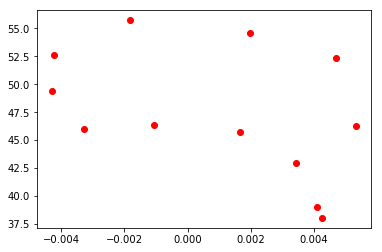

In [26]:
d=0
py.plot(dT_by_dy[d,:,0]*1000,storm_pos_N[d,:],'ro')
#py.plot(dT_by_dy[d,:,1],storm_pos_S[d,:],'bo')

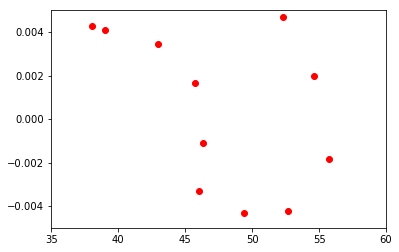

In [28]:
d=0
M=12
if M<13:
    for m in range(M):
        py.plot(storm_pos_N[d,m],dT_by_dy[d,m,0]*1000,'ro')
        py.ylim(-0.005,0.005)
        py.xlim(35,60)
    #py.plot(dT_by_dy[d,:,1],storm_pos_S[d,:],'bo')
else :
    M=1
    for m in range(M):
        py.plot(storm_pos_N[d,m],dT_by_dy[d,m,0]*1000,'ro')
        py.ylim(-0.005,0.005)
        py.xlim(35,60)

(0, 80)

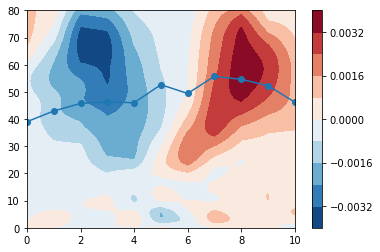

In [37]:
d=0
v=np.linspace(-0.005,0.005,20)
py.contourf(range(11),lat[:], (div_Ts[d,:,1:]-div_Ts[d,:,:-1])*1000**1,10,cmap=BuRd);py.colorbar()
py.plot(range(11),storm_pos_N[d,1:],'o-')
py.ylim(0,80)

(0, 80)

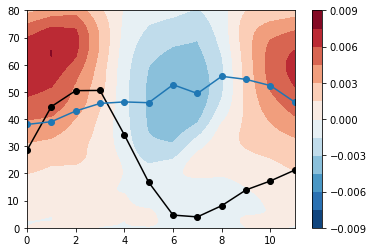

In [47]:
d=0
v=np.linspace(-0.005,0.005,20)
py.contourf(range(12),lat[:], (div_Ts[d,:,:])*1000**1,10,cmap=BuRd);py.colorbar()
py.plot(range(12),Intensity_teN[d,:]*5,'ko-')
py.plot(range(12),storm_pos_N[d,],'o-')
py.ylim(0,80)

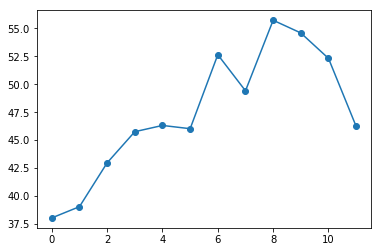

In [48]:
py.plot(range(12),storm_pos_N[d,],'o-')

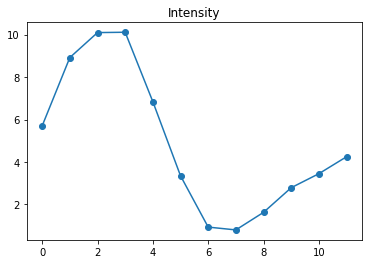

In [45]:
d=0
py.plot(range(12),Intensity_teN[d,:],'o-')
py.title('Intensity')

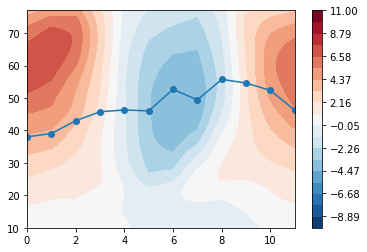

In [39]:
v=np.linspace(-10,11,20)
py.contourf(range(12),lat[len(lat)/2+100:-100], div_Ts[d,len(lat)/2+100:-100,:]*1000**2,v,cmap=BuRd);py.colorbar()
py.plot(range(12),storm_pos_N[d,:],'o-')

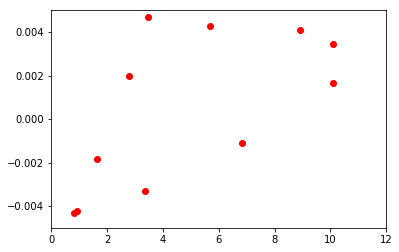

In [42]:
d=0
M=12
if M<13:
    for m in range(M):
        py.plot(Intensity_teN[d,m],dT_by_dy[d,m,0]*1000,'ro')
        py.ylim(-0.005,0.005)
        py.xlim(0,12)
    #py.plot(dT_by_dy[d,:,1],storm_pos_S[d,:],'bo')
else :
    M=1
    for m in range(M):
        py.plot(Intensity_teN[d,m],dT_by_dy[d,m,0]*1000,'ro')
        py.ylim(-0.005,0.005)
        py.xlim(0,12)

In [41]:
Intensity_teN.shape

(4, 12)

In [394]:
intensity_

NameError: name 'intensity_teN' is not defined

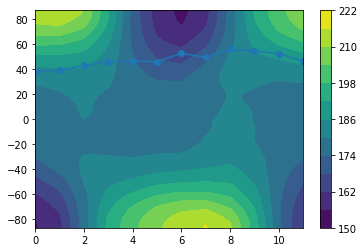

In [298]:

py.contourf(range(12),latn, Ts_interp[d,:,:].transpose(),10);py.colorbar()
py.plot(range(12),storm_pos_N[d,:],'o-')

0


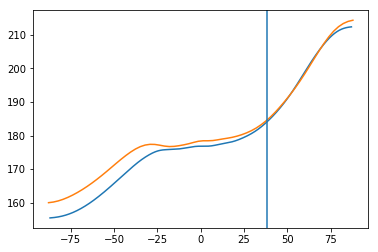

In [288]:
m=0
py.plot(latn,Ts_interp[0,m,:])
py.plot(coord['lat'],Ts[0,m+1,:])
py.axvline(storm_pos_N[d,m])
print m

4


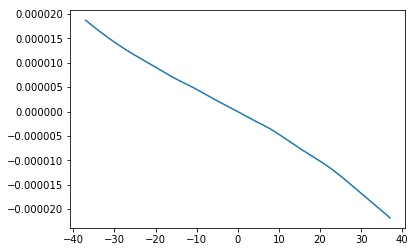

In [294]:
m=m+1

py.plot(latn[500:-500],div_Ts[0,500:-500,m])
# py.plot(latn,div_Ts[0,:,m+1])
# py.axvline(storm_pos_N[d,m])
print m

In [14]:
TE=[]; MM=[]; SE=[]; INE=[]
for depth in range(4):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
    INE.append(TE[depth]+SE[depth]+MM[depth])

In [15]:
lat=latn
import scipy.integrate as integrate
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    #int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:])#int_x_r[:-1,:]) #int_x[::-1,:][1:,:]+
    return avg_int_r/10**15

In [16]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[]

swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];

for depth in range(4):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])   

In [17]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE)
lat=div[0]['latn']

1


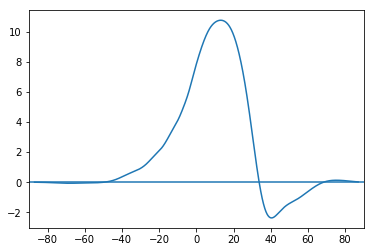

In [163]:
d=0;m=1

if m<12:
    py.plot(lat,MM[d,:,m])
    py.axhline(0)
    py.xlim(-90,90)
else :
    m=0 
    py.plot(lat,MM[d,:,m])
    py.axhline(0)
    py.xlim(-50,-50)
print m

# py.ylim(-0.1,0.1)

In [135]:
from scipy.interpolate import interp1d
def find_zero(flux,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
         l_range=((lat>=20) & (lat<=50)) 
         if ((m>=6) & (m<=7)):
            l_range=((lat>=62) & (lat<=90))
         if (m==8):
            l_range=((lat>=33) & (lat<=60))
         if m>9 :
            l_range=((lat>=40) & (lat<=70))
        else    :
         l_range=((lat>=20) & (lat<=50)) 
         if ((m>=6) & (m<=7)):
            l_range=((lat>=62) & (lat<=90))
         if (m==0):
            l_range=((lat>=-60) & (lat<=-40))
         if m>9 :
            l_range=((lat>=40) & (lat<=70))
         l_range=((lat>=-70) & (lat<=-10))                    
        interpolation_function = interp1d(flux[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan        
  return zero_loc

HC_N=np.zeros((4,12)) ; HC_S=np.zeros((4,12));
for d in range(1):
    HC_N[d,:]=find_zero(MM[d,...],+1)
    HC_S[d,:]=find_zero(MM[d,...],-1)

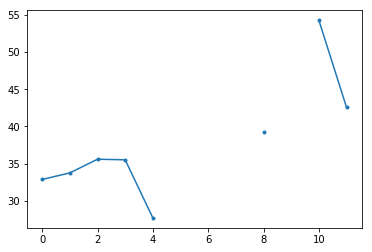

In [139]:
py.plot(HC_N[0,:],'.-')

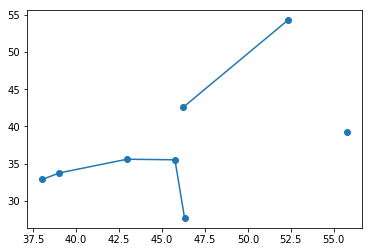

In [171]:
# py.plot(storm_pos_N[0,:],'o-')
# py.plot(HC_N[0,:],'o-')

py.plot(storm_pos_N[0,:],HC_N[0,:],'o-')

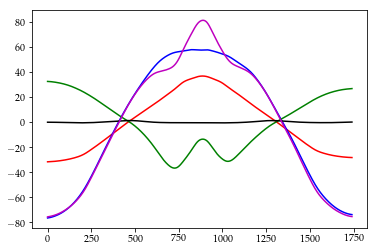

In [948]:
d=3
py.plot(swabs[d][:].mean(axis=1)-swabs[d].mean(),'r-')
py.plot(shf[d][:].mean(axis=1)-shf[d].mean(),'b-')
py.plot( -(olr[d][:].mean(axis=1)-olr[d].mean()),'g-')
py.plot(dhdt[d][:].mean(axis=1)-dhdt[d].mean(),'k-')
py.plot(ne[d][:].mean(axis=1)-ne[d].mean(),'m-')

In [164]:
lat=div[0]['latn']

from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
         l_range=((lat>=30) & (lat<=60))            
        else    :
         l_range=((lat>=-60) & (lat<=-30))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan

        
  return zero_loc

storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
for d in range(4):
    storm_pos_N[d,:]=find_zero(div_TE[d],+1)
    storm_pos_S[d,:]=find_zero(div_TE[d],-1)

In [14]:
storm_pos_N

array([[ 38.03099062,  39.03848672,  42.96535059,  45.75518014,
         46.31516452,  46.02372205,  52.65170134,  49.41847359,
         55.73923737,  54.60053821,  52.32267599,  46.23142573],
       [ 40.96780213,  38.27950412,  38.40224852,  37.78628105,
         40.32160234,  40.54244684,  43.1970933 ,  46.99732412,
         45.12375976,  42.92188489,  48.61572948,  46.2405821 ],
       [ 39.02986085,  38.51637707,  38.96765754,  39.23919563,
         38.52763934,  37.98812646,  36.84592803,  37.92056932,
         38.1528366 ,  38.7172705 ,  40.41495397,  40.07399841],
       [ 40.47570549,  39.0481965 ,  39.6338456 ,  38.88411362,
         40.20539229,  38.72054056,  37.38090581,  37.52993939,
         38.26515163,  38.47483867,  38.90653922,  39.48221256]])

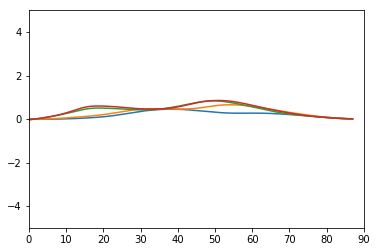

In [15]:
D=4
for d in range(D):
    py.plot(lat,SE[d].mean(axis=-1))
    py.xlim(0,90)
    py.ylim(-5,5)

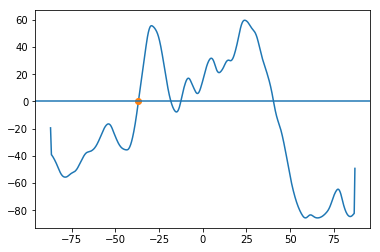

In [16]:
m=0
d=3
py.plot(lat,div_TE[d][:,m],'-')
py.plot(storm_pos_S[d,m],0,'o')
py.axhline(0)

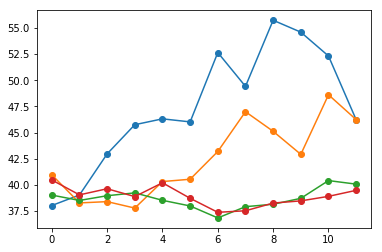

In [17]:
# py.figure(1)
for d in range(4):
    py.plot(storm_pos_N[d,:],'o-')
    #py.plot(-storm_pos_S[d,:],'o--')
py.show()

In [18]:
def plot_flux(n,d) :
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100

    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, 2.0)
    latns=lat
    py.subplot(220+n)
    b = py.contourf(range(13),latns,add(TE[d]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),latns, add(TE[d]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), a(storm_pos_N[d,:]), 'ro-')
    py.plot(range(13), a(storm_pos_S[d,:]), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    py.ylim(-80,80)
    #py.plot(range(13),add2(zero_F_TE_N[:-1]),'ro-',lw=5.8,ms=10)
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-80,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

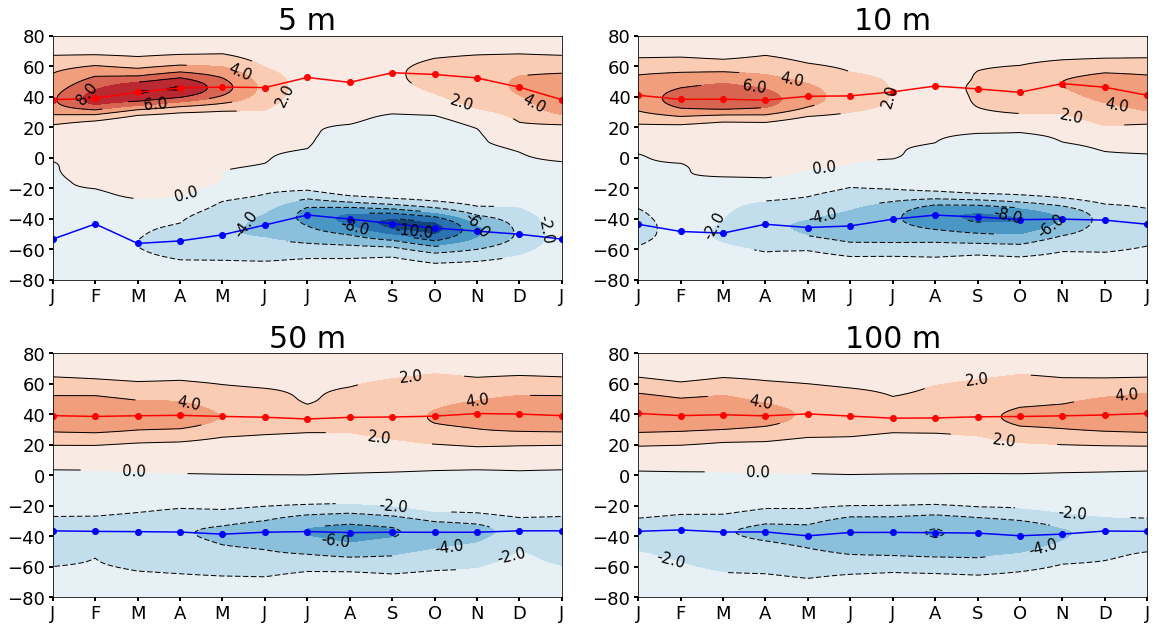

In [19]:
fig=py.figure(figsize=(20, 10))
d=0
plot_flux(d+1,d)
d=1
plot_flux(d+1,d)
d=2
plot_flux(d+1,d)
d=3
plot_flux(d+1,d)

In [32]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,d,N=1):
  D = np.zeros(12)
  for m in range(0,12):
        if N==1 :
          l_range=((lat>=30) & (lat<=60)) 
          X=storm_pos_N
        else    :
          l_range=((lat>=-60) & (lat<=-30))  
          X=storm_pos_S
        interpolation_function = interp1d(lat[l_range],flux[d][l_range,m],kind='cubic')
        try :
            D[m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[m]==np.nan        
  return D

Intensity_teN=np.copy(storm_pos_N)
Intensity_seN=np.copy(storm_pos_N)
Intensity_mmN=np.copy(storm_pos_N)
Intensity_neN=np.copy(storm_pos_N)
for d in range(4):
    Intensity_teN[d,:]=inerp_at_max(TE,d,N=1)
    Intensity_seN[d,:]=inerp_at_max(SE,d,N=1)
    Intensity_mmN[d,:]=inerp_at_max(MM,d,N=1)
    Intensity_neN[d,:]=inerp_at_max(INE,d,N=1)

In [33]:
Intensity_teS=np.copy(storm_pos_S)
Intensity_seS=np.copy(storm_pos_S)
Intensity_mmS=np.copy(storm_pos_S)
Intensity_neS=np.copy(storm_pos_S)
for d in range(4):
    Intensity_teS[d,:]=inerp_at_max(TE,d,N=-1)
    Intensity_seS[d,:]=inerp_at_max(SE,d,N=-1)
    Intensity_mmS[d,:]=inerp_at_max(MM,d,N=-1)
    Intensity_neS[d,:]=inerp_at_max(INE,d,N=-1)

In [34]:
m=m+1
d=0
py.plot(lat, TE[d][:,m])
py.axhline(1)
py.axhline(-1)
py.plot(storm_pos_N[d,m],Intensity_teN[d,m],'ko' )
py.plot(storm_pos_S[d,m],Intensity_teS[d,m],'ko' )
py.ylim(-10,10)
print m

IndexError: index 12 is out of bounds for axis 1 with size 12

In [35]:
def threshold(N, S, pos_N, pos_S):
   p_N=np.copy(pos_N)
   p_S=np.copy(pos_S)
   for d in range(4): 
    for m in range(12):
        if (N[d,m]<+1) :
            p_N[d,m]=np.nan            
        if (S[d,m]>-1) :
            p_S[d,m]=np.nan            
    return p_N, p_S

pos_N, pos_S = threshold(Intensity_teN, Intensity_teS, storm_pos_N, storm_pos_S)            

In [36]:
pos_N

array([[ 38.03099062,  39.03848672,  42.96535059,  45.75518014,
         46.31516452,  46.02372205,          nan,          nan,
         55.73923737,  54.60053821,  52.32267599,  46.23142573],
       [ 40.96780213,  38.27950412,  38.40224852,  37.78628105,
         40.32160234,  40.54244684,  43.1970933 ,  46.99732412,
         45.12375976,  42.92188489,  48.61572948,  46.2405821 ],
       [ 39.02986085,  38.51637707,  38.96765754,  39.23919563,
         38.52763934,  37.98812646,  36.84592803,  37.92056932,
         38.1528366 ,  38.7172705 ,  40.41495397,  40.07399841],
       [ 40.47570549,  39.0481965 ,  39.6338456 ,  38.88411362,
         40.20539229,  38.72054056,  37.38090581,  37.52993939,
         38.26515163,  38.47483867,  38.90653922,  39.48221256]])

In [25]:
def plot_flux(n,d,N) :
    
    pos_N, pos_S = threshold(Intensity_teN, Intensity_teS, storm_pos_N, storm_pos_S)
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100

    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, 1.0)
    latns=lat
    py.subplot(220+n)
    b = py.contourf(range(13),latns,add(TE[d]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),latns, add(TE[d]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), a(pos_N[d,:]), 'ro-')
    py.plot(range(13), a(pos_S[d,:]), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    #py.plot(range(13),add2(zero_F_TE_N[:-1]),'ro-',lw=5.8,ms=10)
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-80,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    if N==1 :
        py.ylim(0,80)
    if N==-1 :
        py.ylim(-80,0)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

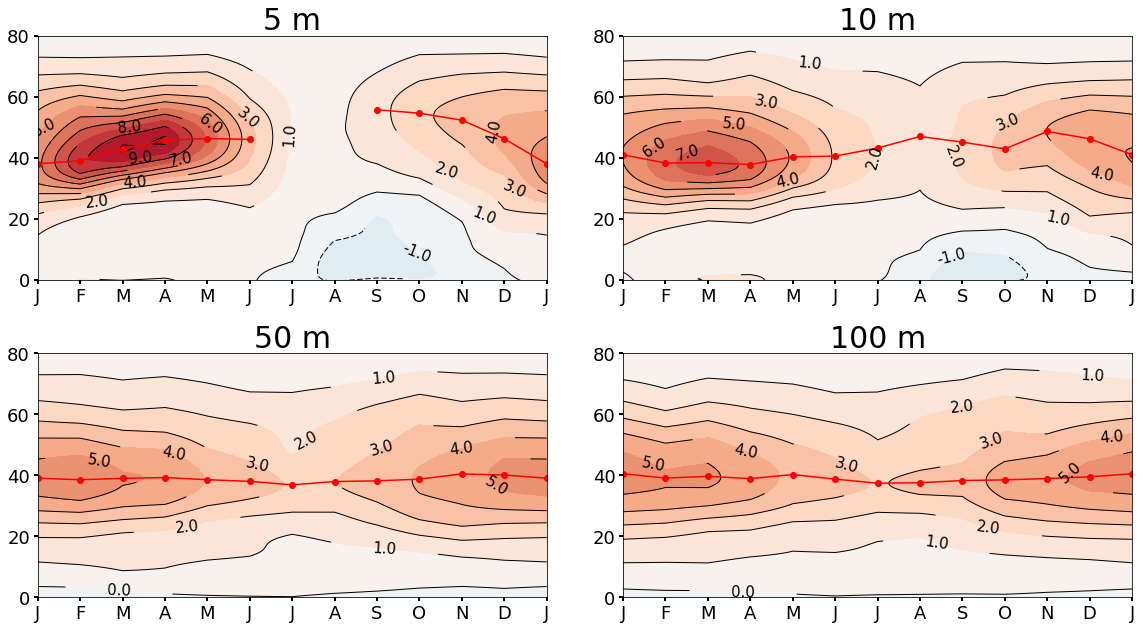

In [26]:
fig=py.figure(figsize=(20, 10))
d=0
plot_flux(d+1,d,1)
d=1
plot_flux(d+1,d,1)
d=2
plot_flux(d+1,d,1)
d=3
plot_flux(d+1,d,1)

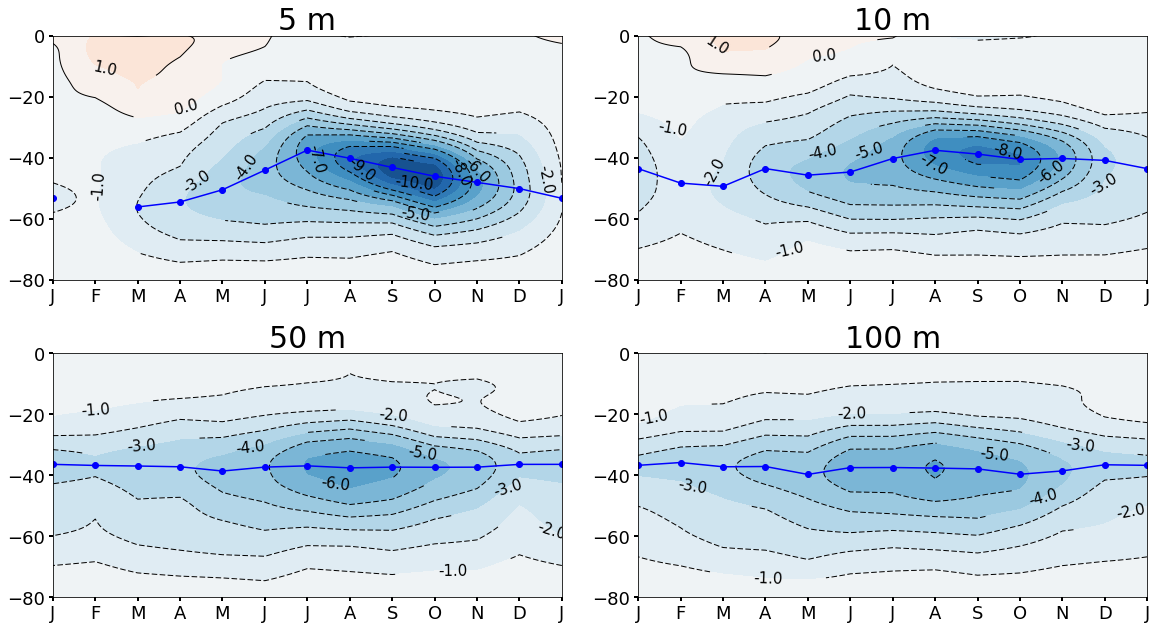

In [27]:
fig=py.figure(figsize=(20, 10))
d=0
plot_flux(d+1,d,-1)
d=1
plot_flux(d+1,d,-1)
d=2
plot_flux(d+1,d,-1)
d=3
plot_flux(d+1,d,-1)

3


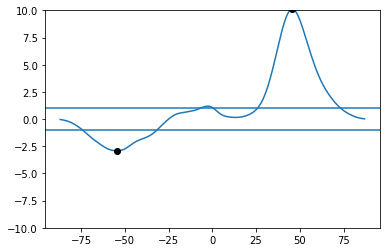

In [29]:
m=m+1
d=0
py.plot(lat, TE[d][:,m])
py.axhline(1)
py.axhline(-1)
py.plot(storm_pos_N[d,m],Intensity_teN[d,m],'ko' )
py.plot(storm_pos_S[d,m],Intensity_teS[d,m],'ko' )
py.ylim(-10,10)
print m

In [30]:
def interp_rad(rad,N=1):
  D = np.zeros((4,12))
  for m in range(0,12):
       for d in range(0,4) :
            latr=lat[1:-1]
            if N==1 :
              l_range=((latr>=30) & (latr<=70)) 
              X=storm_pos_N
            else    :
              l_range=((latr>=-70) & (latr<=-30))  
              X=storm_pos_S
            interpolation_function = interp1d(latr[l_range],rad[d][l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [31]:
I_SWAB_N =interp_rad((Iswabs),N=1)
I_SHF_N  =interp_rad((Ishf),N=1)
I_NE_N   =interp_rad((Ine),N=1)
I_OLR_N  =interp_rad((Iolr),N=1)
I_dhdt_N =interp_rad((Idhdt),N=1)

In [32]:
I_SWAB_S =interp_rad((Iswabs),N=-1)
I_SHF_S  =interp_rad((Ishf),N=-1)
I_NE_S  =interp_rad((Ine),N=-1)
I_OLR_S  =interp_rad((Iolr),N=-1)
I_dhdt_S =interp_rad((Idhdt),N=-1)

1


(0, 90)

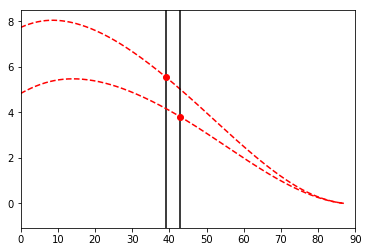

In [33]:
m=1
print m
py.plot(lat[1:-1],M(Iswabs)[0][:,m],'r--')
py.axvline(storm_pos_N[0,m],color='k')
py.plot(storm_pos_N[0,m],I_SWAB_N[0,m],'ro')

py.plot(lat[1:-1],M(Iswabs)[0][:,m+1],'r--')
py.axvline(storm_pos_N[0,m+1],color='k')
py.plot(storm_pos_N[0,m+1],I_SWAB_N[0,m+1],'ro')

py.xlim(0,90)


In [34]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2


In [35]:
def plot_delta_NE(d,N,l):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    fig=py.figure(figsize=(15, 9))        
    if N==1 :    
        py.plot(D(I_NE_N,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(D(I_SWAB_N,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
        py.plot(D(I_SHF_N,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
        py.plot(D(-I_OLR_N,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(Intensity_teN,d),'mo--',label=r'$\Delta I$',lw=2.5)
        
        py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    
    if N==-1 :
        py.plot(D(I_NE_S,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(D(I_SWAB_S,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
        py.plot(D(I_SHF_S,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
        py.plot(D(-I_OLR_S,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5)
        #py.plot(D(Intensity_teS,d),'mo--',label=r'$\Delta I$',lw=2.5)
        
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
    title="NE decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=3,frameon=False, loc='best')
    
   # py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/ISCA/NE_decomposition_NH_100m.pdf


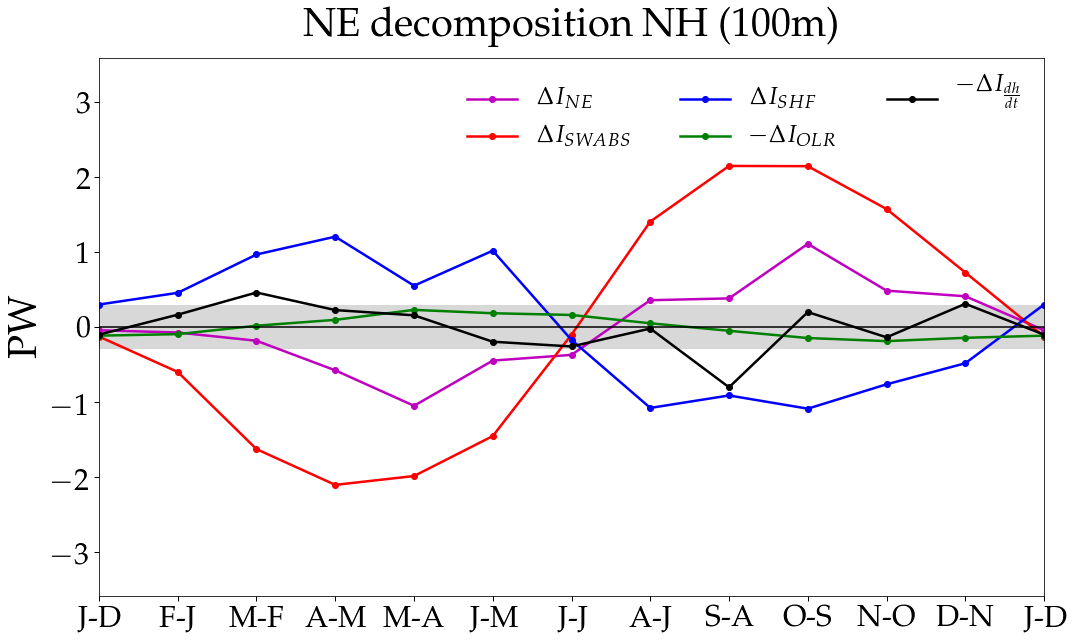

In [36]:
d=3;l=3.6
plot_delta_NE(d,1,l)

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/ISCA/NE_decomposition_SH_100m.pdf


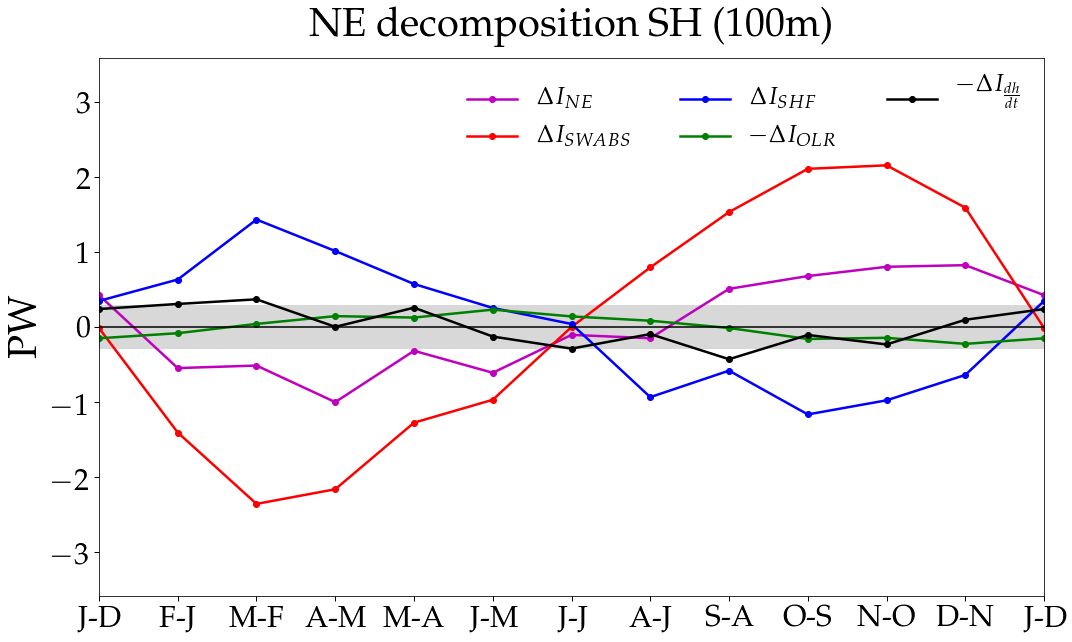

In [37]:
plot_delta_NE(d,-1,l)

2


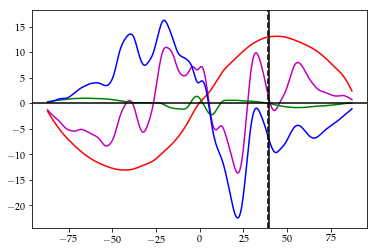

In [38]:
d=3;#m=m+1
m=m+1
def D(Y):
    X=Y*np.cos(np.deg2rad(lat))[:,None]  # -np.average(Y,axis=0,weights=np.cos(np.deg2rad(lat)))
    X=X-X.mean(axis=0)
    return X[:,1:]-X[:,:-1]

py.plot(lat,D(ne[d])[:,m],'m-')
py.plot(lat,D(swabs[d])[:,m],'r-')
py.plot(lat,D(-olr[d])[:,m],'g-')
py.plot(lat,D(shf[d])[:,m],'b-')

py.axvline(storm_pos_N[d,m],color='k')
py.axvline(storm_pos_N[d,m+1],color='k',ls='--')
py.axhline(0,color='k')
print m

In [39]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_intensity(d,N,l):
    
    if d==0: depth=5
    if d==1: depth=10
    if d==2: depth=50
    if d==3: depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    fig=py.figure(figsize=(15, 9))        
    if N==1 :    
        py.plot(D(Intensity_teN,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neN,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
        py.plot(-D(Intensity_seN,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmN,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
        #py.plot(D(Intensity_teN+Intensity_seN+Intensity_mmN,d),'yo--',label="tot",lw=2.5)     
    if N==-1 :
        py.plot(D(Intensity_teS,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neS,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(-D(Intensity_seS,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmS,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
    title="Intensity decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/ISCA/Intensity_decomposition_SH_100m.pdf


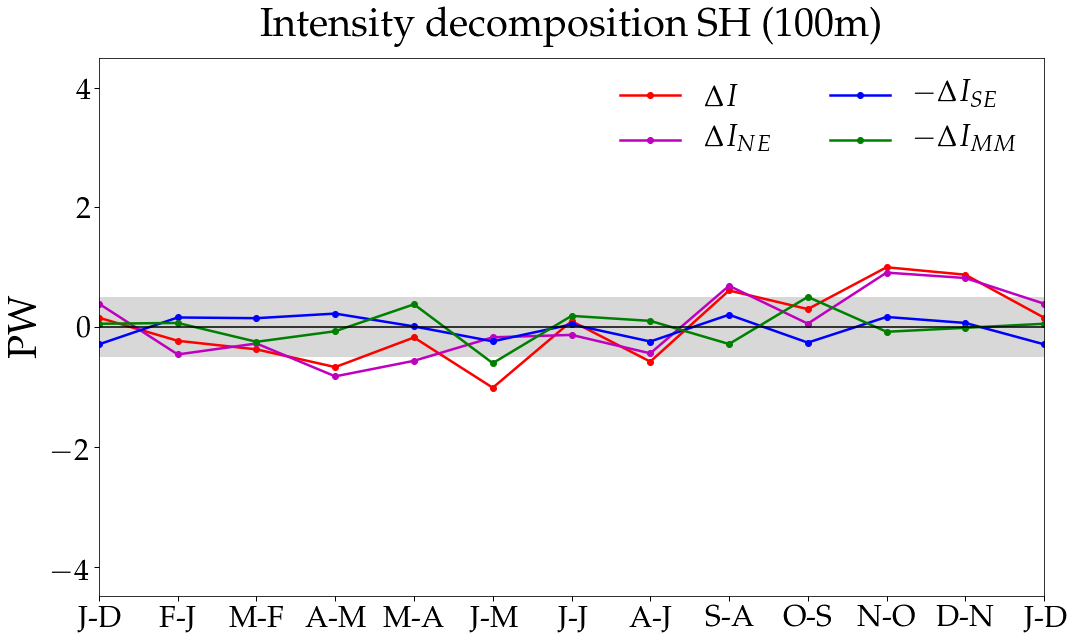

In [40]:
d=3;N=-1;l=4.5
plot_intensity(d,N,l)

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/ISCA/Intensity_decomposition_NH_100m.pdf


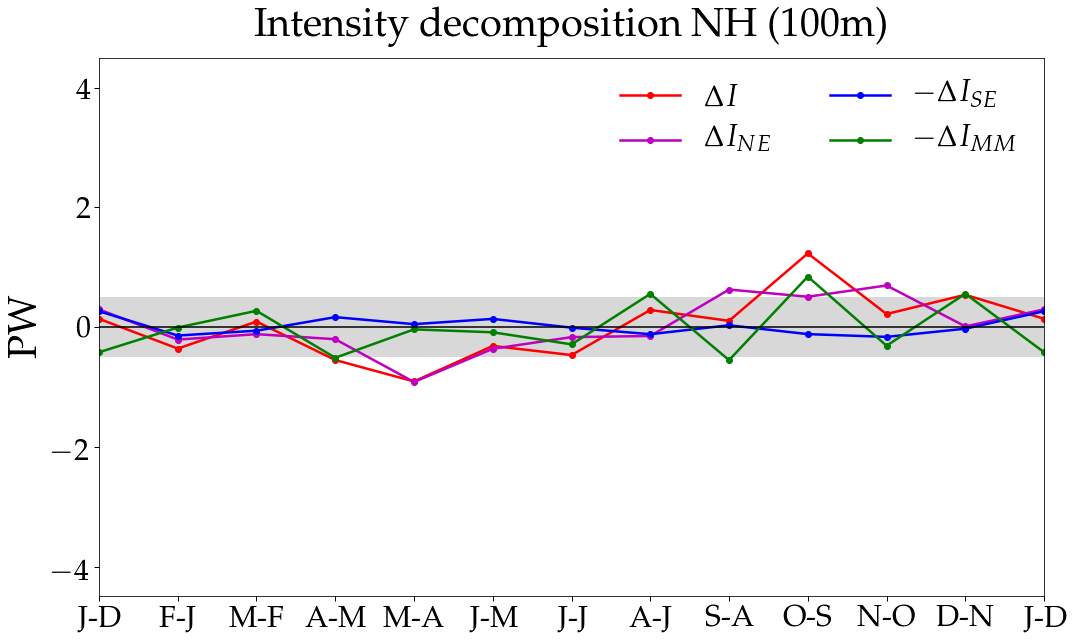

In [41]:
d=3;N=1;l=4.5
plot_intensity(d,N,l)

# Storm track shift decomposition

In [325]:
SE_change=np.zeros((4,len(lat),13))
MM_change=np.zeros((4,len(lat),13))
TE_change=np.zeros((4,len(lat),13))
NE_change=np.zeros((4,len(lat),13))

def calculate_shift_just_by_adding_individual_flux_divergences():
    
    se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)
    
    div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
    div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
    div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
    div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)
    
    for month in range(0,12):

        del_div_SE1=div_se[:,:,month+1]-div_se[:,:,month]
        del_div_MM1=div_mm[:,:,month+1]-div_mm[:,:,month]
        del_div_TE1=div_te[:,:,month+1]-div_te[:,:,month]
        del_div_NE1=div_ne[:,:,month+1]-div_ne[:,:,month]
        
        SE_change[:,:,month+1]=te[:,:,month]-del_div_SE1
        MM_change[:,:,month+1]=te[:,:,month]-del_div_MM1
        TE_change[:,:,month+1]=te[:,:,month]+del_div_TE1
        NE_change[:,:,month+1]=te[:,:,month]+del_div_NE1

    SE_change[:,:,0]=SE_change[:,:,12]
    TE_change[:,:,0]=TE_change[:,:,12]
    MM_change[:,:,0]=MM_change[:,:,12]
    NE_change[:,:,0]=NE_change[:,:,12]
    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences()

In [324]:
# storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
# for d in range(4):
#     storm_pos_N[d,:]=find_zero(div_TE[d,...],+1)
#     storm_pos_S[d,:]=find_zero(div_TE[d,...],-1)

from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(13)
  for m in range(0,13):
        if N==1 :
         l_range=((lat>=32) & (lat<=70))            
        else    :
         l_range=((lat>=-70) & (lat<=-32))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan
        
  return zero_loc

def plot_monthly_shift_method2(N,d,l) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    zero_div_TE=find_zero(TE_change[d,...],N)
    zero_div_SE=find_zero(SE_change[d,...],N)
    zero_div_MM=find_zero(MM_change[d,...],N)
    zero_div_NE=find_zero(NE_change[d,...],N)
    
    if N==1 :
        I=Intensity_teN
    if N==-1 :
        I=Intensity_teS
        
    def threshold(I, pos1, pos2, pos3, pos4):
        I=np.append(I[-1],I)
        for m in range(13):
            if (np.abs(I[m])<+1) :
                #N[d,m]=np.nan
                pos1[m]=np.nan
                pos2[m]=np.nan
                pos3[m]=np.nan
                pos4[m]=np.nan                
#                 print ok
        return pos1, pos2, pos3, pos4

    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
                
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y

    TE_obs         = add_month_to_end(zero_div_TE[1:]-zero_div_TE[:-1])
    SE             = add_month_to_end(zero_div_SE[1:]-zero_div_TE[:-1])
    MM             = add_month_to_end(zero_div_MM[1:]-zero_div_TE[:-1])
    NE             = add_month_to_end(zero_div_NE[1:]-zero_div_TE[:-1])
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\delta\: (\textrm{obs})$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\delta_{\textrm{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\delta_{\textrm{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\delta_{\textrm{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'$\textrm{error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    #mticks = [r'$\textrm{J-D}$',r'$\textrm{F-J}$',r'$\textrm{M-F}$',r'$\textrm{A-M}$',r'$\textrm{M-A}$', r'$\textrm{J-M}$',r'$\textrm{J-J}$',r'$\textrm{A-J}$', r'$\textrm{S-A}$', r'$\textrm{O-S}$', r'$\textrm{N-O}$', r'$\textrm{D-N}$', r'$\textrm{J-D}$']
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    #py.ylabel(r"\textrm{Poleward\hspace{ 2mm} Shift \hspace{ 2mm}}$(^{o}\:N)$", fontsize=45)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="stormtrack_shift_decomp_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0  -0.485651 -0.815692 -4.050463 -2.848629    -8.200435
1   4.530386 -5.400356  1.853471  0.023996     1.007496
2   0.283406 -0.669744  4.407978 -0.094776     3.926864
3   0.053263  0.837911  2.183190 -0.284534     2.789830
4   1.469163  1.133318 -1.955049 -0.087449     0.559984
5  -1.388133 -0.501533  1.837168 -0.238945    -0.291442
6   5.959924  0.184212 -0.078628  0.562471     6.627979
7        NaN       NaN       NaN       NaN          NaN
8        NaN       NaN       NaN       NaN          NaN
9        NaN       NaN       NaN       NaN          NaN
10  0.596757 -2.641281  1.668776 -1.902114    -2.277862
11 -2.785217 -1.549422 -1.382409 -0.374202    -6.091250
12 -0.485651 -0.815692 -4.050463 -2.848629    -8.200435


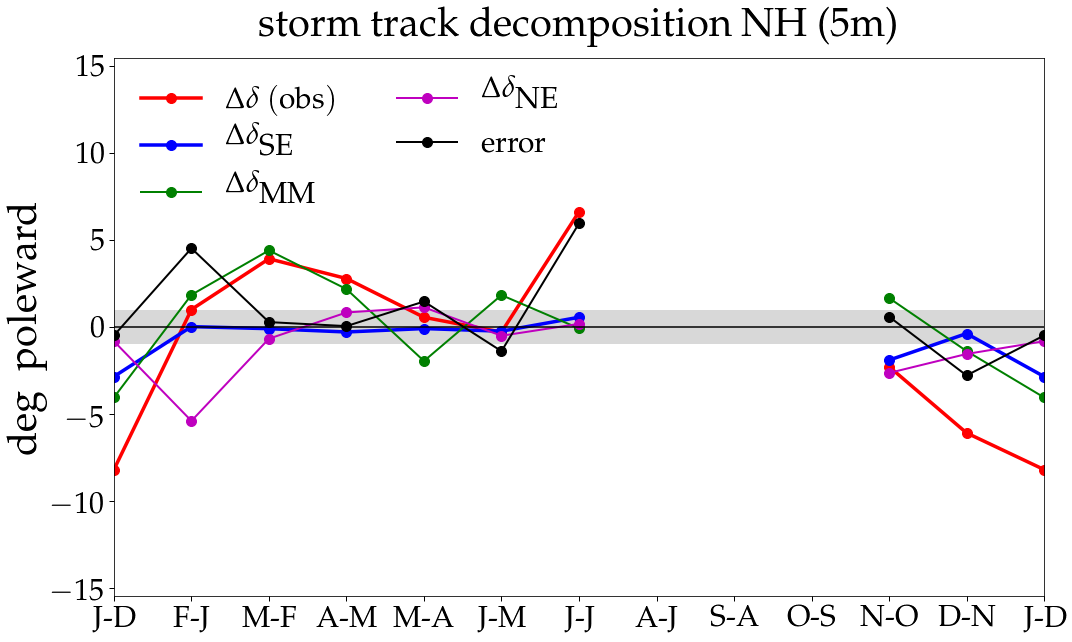

In [44]:
d=0; l=15.5;
plot_monthly_shift_method2(1,d,l)

         err   shiftEI    shiftMM   shiftSE  shiftTE_obs
0  -1.160121  1.341957  -4.694676  1.330770    -3.182071
1   1.244236 -2.057942  11.635593 -0.915070     9.906816
2        NaN       NaN        NaN       NaN          NaN
3        NaN       NaN        NaN       NaN          NaN
4  -1.127816  2.427123  -1.208932  3.906962     3.997337
5  -0.808872 -0.104709   5.224244  2.127275     6.437939
6  -1.867965  1.067172   4.462786  2.892324     6.554317
7  -3.298587  3.961741  -3.563947  0.225854    -2.674939
8  -0.489818  0.701845  -3.396840  0.181770    -3.003043
9  -0.007163 -0.990602  -2.280405  0.384015    -2.894156
10 -1.692491 -1.377600   1.166873 -0.108755    -2.011973
11 -0.157092 -0.737878  -1.587077  0.454312    -2.027735
12 -1.160121  1.341957  -4.694676  1.330770    -3.182071


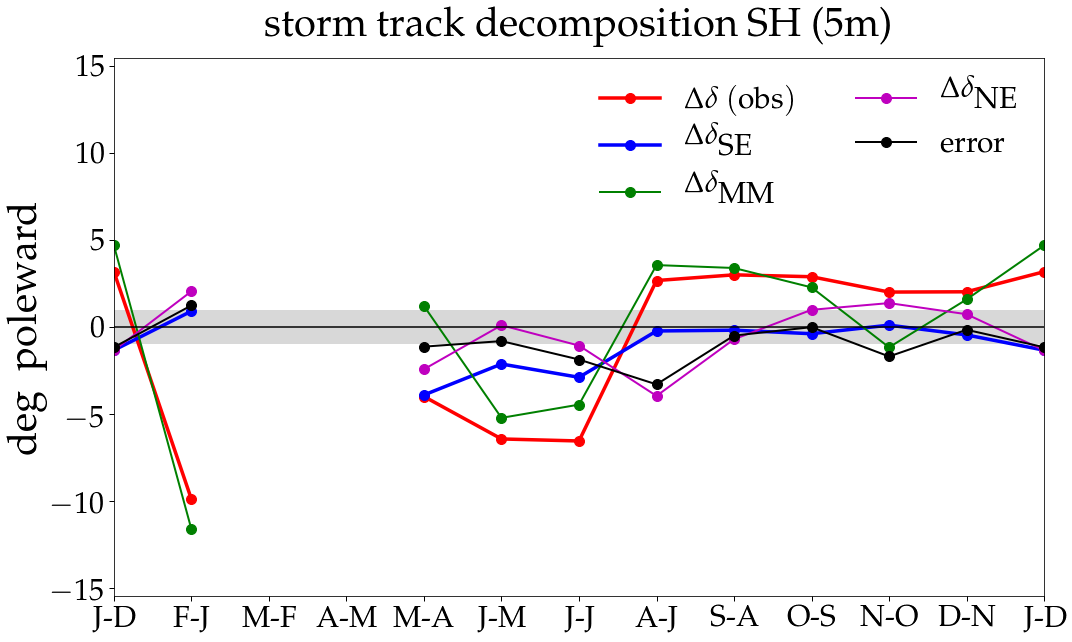

In [45]:
l=15.5
plot_monthly_shift_method2(-1,d,l)

In [46]:
d=2;N=1
zero_div_TE=find_zero(TE_change[d,...],N)
zero_div_SE=find_zero(SE_change[d,...],N)
zero_div_MM=find_zero(MM_change[d,...],N)
zero_div_NE=find_zero(NE_change[d,...],N)

def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y

TE_obs         = add_month_to_end(zero_div_TE[1:]-zero_div_TE[:-1] )
SE             = add_month_to_end(zero_div_SE[1:]-zero_div_TE[:-1])
MM             = add_month_to_end(zero_div_MM[1:]-zero_div_TE[:-1])
NE             = add_month_to_end(zero_div_NE[1:]-zero_div_TE[:-1])
TE_calc        = SE+MM+NE
nonlinear_error= TE_obs-TE_calc


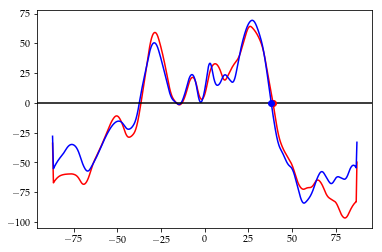

In [47]:
m=0
py.plot(lat,TE_change[d,:,m],'r-')
py.plot(lat,MM_change[d,:,m+1],'b-')
py.axhline(0,color='k')
py.plot(zero_div_TE[m],0,'ro')
py.plot(zero_div_MM[m+1],0,'bo')


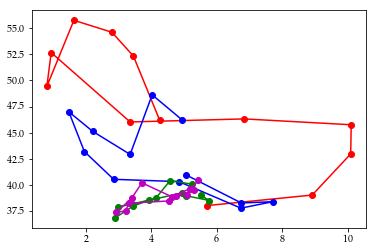

In [48]:
d=0
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'ro-')
d=1
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'bo-')
d=2
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'go-')
d=3
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'mo-')

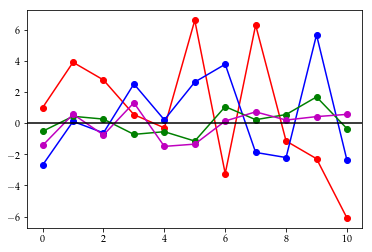

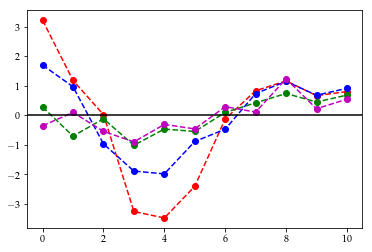

In [49]:
m = lambda x: x[1:]-x[:-1]

py.figure(1)
d=0
py.plot(m(storm_pos_N[d,:]),'ro-')
d=1
py.plot(m(storm_pos_N[d,:]),'bo-')
d=2
py.plot(m(storm_pos_N[d,:]),'go-')
d=3
py.plot(m(storm_pos_N[d,:]),'mo-')
py.axhline(0,color='k')

py.figure(2)
d=0
py.plot(m(Intensity_teN[d,:]),'ro--')
d=1
py.plot(m(Intensity_teN[d,:]),'bo--')
d=2
py.plot(m(Intensity_teN[d,:]),'go--')
d=3
py.plot(m(Intensity_teN[d,:]),'mo--')
py.axhline(0,color='k')

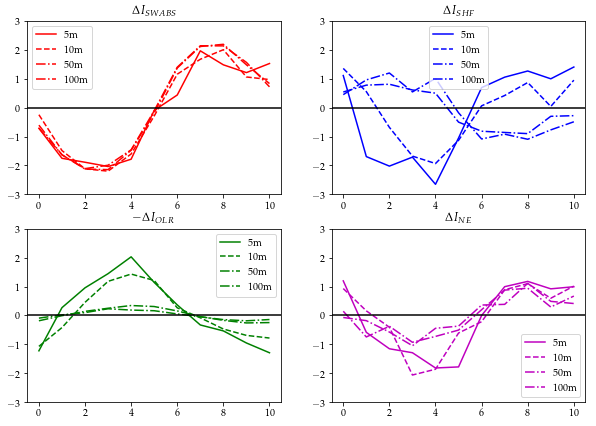

In [50]:
def compare_plot(n,X,c,T,l=3):
    py.subplot(220+n)
    d=0
    def diff(Y):
        return Y[1:]-Y[:-1]
    py.plot(diff(X[d,:]),c+'-',label='5m')
    py.plot(diff(X[d+1,:]),c+'--',label='10m')
    py.plot(diff(X[d+2,:]),c+'-.',label='50m')
    py.plot(diff(X[d+3,:]),c+'-.',label='100m')
    py.legend(loc='best')
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T)

fig=py.figure(figsize=(10, 7))
compare_plot(1,I_SWAB_N,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF_N,'b',r'$\Delta I_{SHF}$')
compare_plot(3,-I_OLR_N,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE_N,'m',r'$\Delta I_{NE}$')

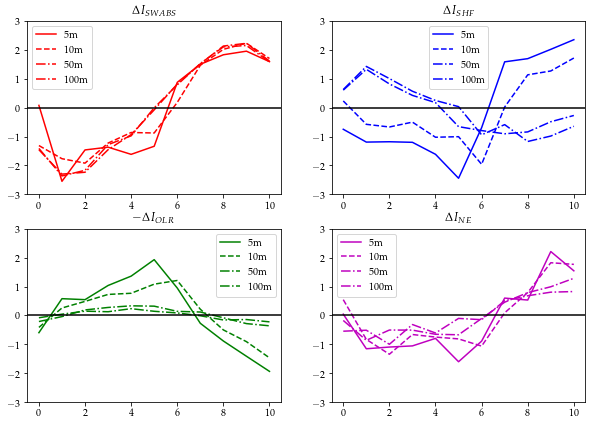

In [51]:
fig=py.figure(figsize=(10, 7))
compare_plot(1,I_SWAB_S,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF_S,'b',r'$\Delta I_{SHF}$')
compare_plot(3,-I_OLR_S,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE_S,'m',r'$\Delta I_{NE}$')

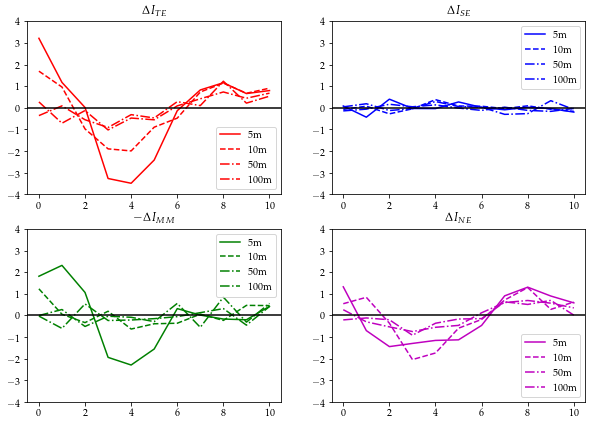

In [52]:
fig=py.figure(figsize=(10, 7))
compare_plot(1,Intensity_teN,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_seN,'b',r'$\Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mmN,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_neN,'m',r'$\Delta I_{NE}$',l=4)

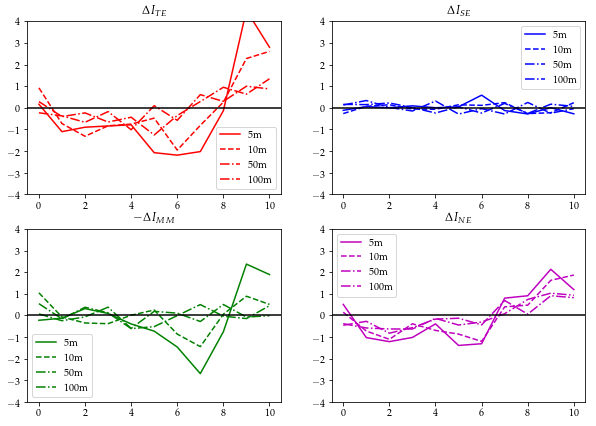

In [54]:
fig=py.figure(figsize=(10, 7))
compare_plot(1,Intensity_teS,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_seS,'b',r'$\Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mmS,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_neS,'m',r'$\Delta I_{NE}$',l=4)

# Try decomposing by calculating the shift from mean values

In [55]:
SE_change=np.zeros((4,len(lat),12))
MM_change=np.zeros((4,len(lat),12))
TE_change=np.zeros((4,len(lat),12))
NE_change=np.zeros((4,len(lat),12))

def calculate_changes_from_mean():
    
    se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)
    
#     div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
#     div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
#     div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
#     div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)

    for month in range(0,12):

        del_div_SE1=se[:,:,month]-se.mean(axis=-1)
        del_div_MM1=mm[:,:,month]-mm.mean(axis=-1)
        del_div_TE1=te[:,:,month]-te.mean(axis=-1)
        del_div_NE1=ne[:,:,month]-ne.mean(axis=-1)
        
        SE_change[:,:,month]=te.mean(axis=-1)-del_div_SE1
        MM_change[:,:,month]=te.mean(axis=-1)-del_div_MM1
        TE_change[:,:,month]=te.mean(axis=-1)+del_div_TE1
        NE_change[:,:,month]=te.mean(axis=-1)+del_div_NE1

    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_changes_from_mean()

0


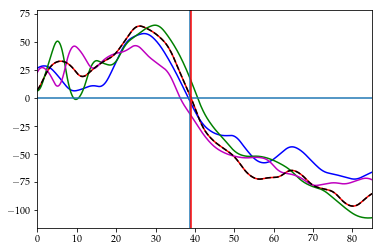

In [57]:
d=2;
m=0;
py.plot(lat,TE_change[d,:,m],'r-')
py.plot(lat,SE_change[d,:,m],'b-')
py.plot(lat,MM_change[d,:,m],'g-')
py.plot(lat,NE_change[d,:,m],'m-')
py.plot(lat,div_TE[d][:,m],'k--')
py.xlim(0,85)
#py.ylim(-125,125)
py.axhline(0)
py.axvline(storm_pos_N[d,:].mean())
py.axvline(storm_pos_N[d,m],color='r')
print m

In [58]:
d=3
print storm_pos_N[d,:].mean()

def find_zero(div,N=1):
        if N==1 :
         l_range=((lat>=35) & (lat<=70))            
        else    :
         l_range=((lat>=-70) & (lat<=-35))                    
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan
        
        return zero_loc

print find_zero(TE_change[d,...].mean(axis=-1),N=1)

38.9172817781
38.8263643552


In [235]:
from scipy.interpolate import interp1d

def find_zero(div,N=1,mean='no'):   
  if N==1 :
     l_range=((lat>=35) & (lat<=70))            
  if N==-1:
    l_range=((lat>=-70) & (lat<=-32))  
    
  if mean == 'no' :
      zero_loc = np.zeros(12)
      for m in range(0,12): 
            if N==1 :
                interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
            if N==-1 :
                interpolation_function = interp1d(div[l_range,m][::-1],lat[l_range][::-1],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan
  if mean == 'yes' :
                   
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan
            
  return zero_loc

def plot_shift_from_mean_method2(N,d,l) :
        
    if d==0: depth=5
    if d==1: depth=10
    if d==2: depth=50
    if d==3: depth=100
     
    zero_div_TE=find_zero(TE_change[d,...],N)
    zero_div_SE=find_zero(SE_change[d,...],N)
    zero_div_MM=find_zero(MM_change[d,...],N)
    zero_div_NE=find_zero(NE_change[d,...],N)
    
    mean_pos_TE=find_zero(TE_change[d,...].mean(axis=-1),N,mean='yes')
    
    print mean_pos_TE
    
    if N==1 :
        I=Intensity_teN
    if N==-1 :
        I=Intensity_teS
        
    def threshold(I, pos1, pos2, pos3, pos4):
        I=np.append(I[-1],I)
        for m in range(13):
            if (np.abs(I[m])<+1) :
                #N[d,m]=np.nan
                pos1[m]=np.nan
                pos2[m]=np.nan
                pos3[m]=np.nan
                pos4[m]=np.nan                
        return pos1, pos2, pos3, pos4

    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
                
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1,y1[0])
        return y

    TE_obs         = add_month_to_end(zero_div_TE-mean_pos_TE)
    SE             = add_month_to_end(zero_div_SE-mean_pos_TE)
    MM             = add_month_to_end(zero_div_MM-mean_pos_TE)
    NE             = add_month_to_end(zero_div_NE-mean_pos_TE)
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\phi_{ ({obs})}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    #mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    #py.ylabel(r"\textrm{Poleward\hspace{ 2mm} Shift \hspace{ 2mm}}$(^{o}\:N)$", fontsize=45)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="stormtrack_shift_decomp_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

-44.5256376792
         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0        NaN -3.452497       NaN  1.136978    -8.749689
1        NaN -3.640647       NaN  0.927828     1.157127
2        NaN       NaN       NaN       NaN          NaN
3  -1.832071 -0.057372 -4.070096 -3.985827    -9.945366
4   2.409138  0.481016 -7.470782 -1.367399    -5.948029
5  -1.186285  0.738228  1.663783 -0.725817     0.489910
6  -1.464044  1.216265  6.804126  0.487881     7.044227
7  -7.614022  8.723377  3.090889  0.169044     4.369288
8  -7.801717  9.808996  0.124825 -0.765860     1.366245
9  -1.994965  1.912304 -2.246027  0.800777    -1.527911
10  0.912479 -3.017659 -1.902979  0.468276    -3.539883
11       NaN -4.570432       NaN  0.326223    -5.567618
12       NaN -3.452497       NaN  1.136978    -8.749689


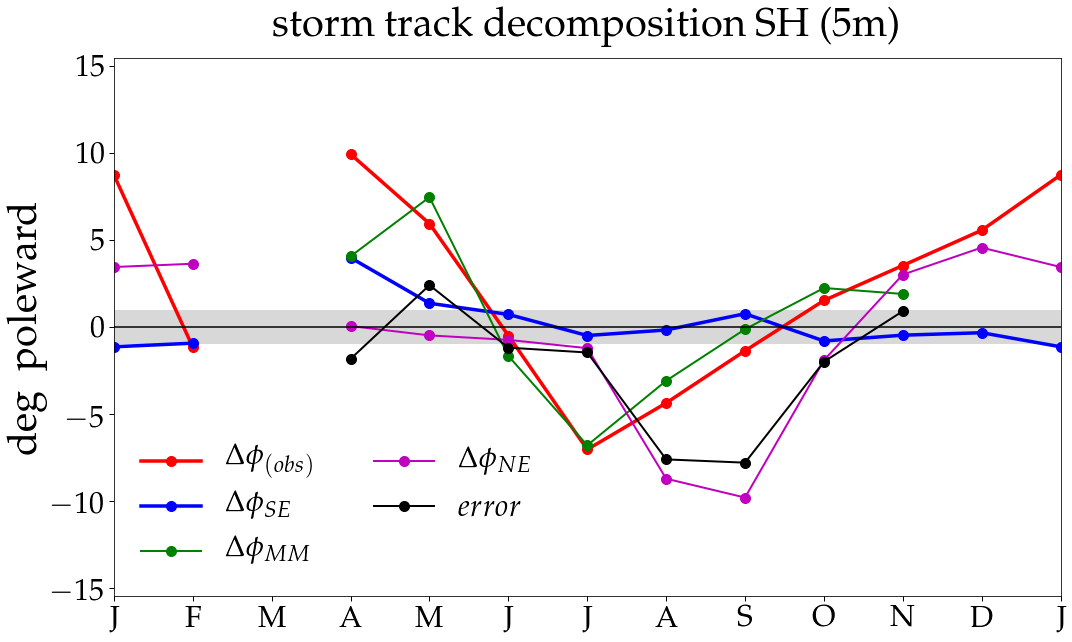

In [239]:
d=0; l=15.5;
N=-1
plot_shift_from_mean_method2(N,d,l)

44.5832368526
         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0   1.558900 -2.272193 -5.783528 -0.055425    -6.552246
1   2.464824 -3.770034 -4.283003  0.043463    -5.544750
2   6.538168 -8.035512 -0.512430  0.391889    -1.617886
3   1.871061 -1.934853  1.623842 -0.388107     1.171943
4  -1.501824  3.588657  0.378130 -0.733036     1.731928
5        NaN  2.575667       NaN -1.068751     1.440485
6        NaN  2.990124       NaN -0.746014     8.068464
7        NaN       NaN       NaN       NaN          NaN
8        NaN       NaN       NaN       NaN          NaN
9   3.059806  0.471195  6.802098 -0.315798    10.017301
10 -3.224778 -0.570578  9.582733  1.952062     7.739439
11 -3.936854 -1.594716  5.935530  1.244229     1.648189
12  1.558900 -2.272193 -5.783528 -0.055425    -6.552246


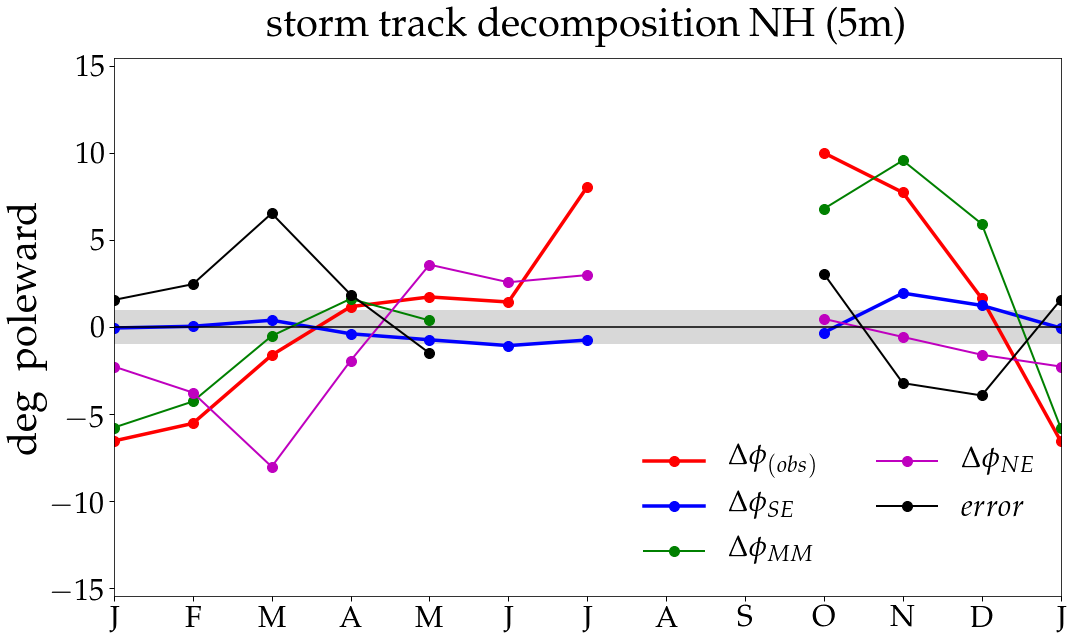

In [240]:
d=0; l=15.5;
N=1
plot_shift_from_mean_method2(N,d,l)

-44.5256376792
         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0        NaN -3.452497       NaN  1.136978    -8.749689
1        NaN -3.640647       NaN  0.927828     1.157127
2        NaN       NaN       NaN       NaN          NaN
3  -1.832071 -0.057372 -4.070096 -3.985827    -9.945366
4   2.409138  0.481016 -7.470782 -1.367399    -5.948029
5  -1.186285  0.738228  1.663783 -0.725817     0.489910
6  -1.464044  1.216265  6.804126  0.487881     7.044227
7  -7.614022  8.723377  3.090889  0.169044     4.369288
8        NaN       NaN  0.124825 -0.765860     1.366245
9  -1.994965  1.912304 -2.246027  0.800777    -1.527911
10  0.912479 -3.017659 -1.902979  0.468276    -3.539883
11       NaN -4.570432       NaN  0.326223    -5.567618
12       NaN -3.452497       NaN  1.136978    -8.749689


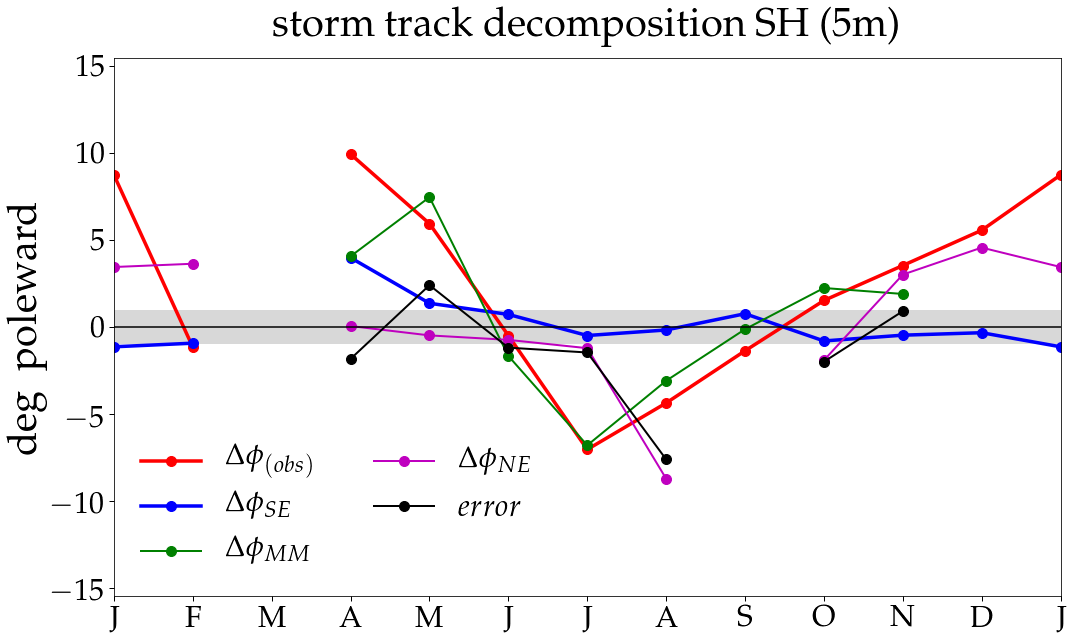

In [109]:
d=0; l=15.5;
N=-1
plot_shift_from_mean_method2(N,d,l)

## Try seasonal shifts averaged over months

In [792]:
def find_zero_seas(div,N=1,mean='no'):   
  if N==1 :
     l_range=((lat>=25) & (lat<=70))            
  if N==-1:
    l_range=((lat>=-70) & (lat<=-25))
  if mean == 'no' :
      zero_loc = np.zeros(np.shape(div)[-1])
      for m in range(0,np.shape(div)[-1]): 
            if N==1 :
                interpolation_function = interp1d(div[l_range,m]      ,lat[l_range]      ,kind='linear')
            if N==-1 :
                interpolation_function = interp1d(div[l_range,m][::-1],lat[l_range][::-1],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan
  if mean == 'yes' :                   
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan                
  return zero_loc

In [793]:
def separate_seasons(X,MO=3):
    season=np.zeros((4,len(lat),12/MO))
    Y=np.append(X[...,-1,None],X[...,:-1],axis=-1)
    for m in range(12):
        if m%MO==0:
            season[:,:,m/MO]=Y[:,:,m:m+MO].mean(axis=-1)
    return season

In [794]:
MO=3
se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)

SE_seas=separate_seasons(se,MO)
TE_seas=separate_seasons(te,MO)
MM_seas=separate_seasons(mm,MO)
NE_seas=separate_seasons(ne,MO)

IndexError: index 4 is out of bounds for axis 2 with size 4

In [796]:
def calculate_shift_just_by_adding_individual_flux_divergences(te, se, mm, ne, M):
    
    SE_change=np.zeros((4,len(lat),M+1))
    MM_change=np.zeros((4,len(lat),M+1))
    TE_change=np.zeros((4,len(lat),M+1))
    NE_change=np.zeros((4,len(lat),M+1))
    
    div_se=np.append(se,se[:,:,0,np.newaxis],axis=-1)
    div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=-1)
    div_te=np.append(te,te[:,:,0,np.newaxis],axis=-1)
    div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=-1)
    
    for month in range(0,M):

        del_div_SE1=div_se[:,:,month+1]-div_se[:,:,month]
        del_div_MM1=div_mm[:,:,month+1]-div_mm[:,:,month]
        del_div_TE1=div_te[:,:,month+1]-div_te[:,:,month]
        del_div_NE1=div_ne[:,:,month+1]-div_ne[:,:,month]
        
        SE_change[:,:,month+1]=te[:,:,month]-del_div_SE1
        MM_change[:,:,month+1]=te[:,:,month]-del_div_MM1
        TE_change[:,:,month+1]=te[:,:,month]+del_div_TE1
        NE_change[:,:,month+1]=te[:,:,month]+del_div_NE1

    SE_change[:,:,0]=SE_change[:,:,-1]
    TE_change[:,:,0]=TE_change[:,:,-1]
    MM_change[:,:,0]=MM_change[:,:,-1]
    NE_change[:,:,0]=NE_change[:,:,-1]
    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(TE_seas, SE_seas,MM_seas, NE_seas, 12/MO)

In [808]:
d=0
zero_div_MM=find_zero_seas(MM_change[d,...],N,'no')
zero_div_SE=find_zero_seas(SE_change[d,...],N,'no')
zero_div_NE=find_zero_seas(NE_change[d,...],N,'no')

4


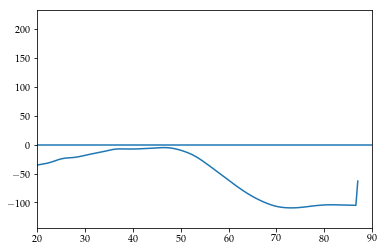

In [820]:
# py.plot(zero_div_TE,'o-')
d=0; m=m+1
if m==5: 
    m=0
py.plot(lat,NE_change[d,:,m])
py.axvline(zero_div_NE[m])
py.axhline(0)
py.xlim(20,90)
print m

In [829]:
def plot_seasonal_shift_method2(N,d,l) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    zero_div_TE=find_zero_seas(TE_change[d,...],N,'no')
    zero_div_SE=find_zero_seas(SE_change[d,...],N,'no')
    zero_div_MM=find_zero_seas(MM_change[d,...],N,'no')
    zero_div_NE=find_zero_seas(NE_change[d,...],N,'no')
    
#     if N==1 :
#         I=Intensity_teN
#     if N==-1 :
#         I=Intensity_teS
        
#     def threshold(I, pos1, pos2, pos3, pos4):
#         I=np.append(I[-1],I)
#         for m in range(13):
#             if (np.abs(I[m])<+1) :
#                 #N[d,m]=np.nan
#                 pos1[m]=np.nan
#                 pos2[m]=np.nan
#                 pos3[m]=np.nan
#                 pos4[m]=np.nan                
# #                 print ok
#         return pos1, pos2, pos3, pos4

#     zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
        
    final= zero_div_TE.shape[-1]
    m=range(0,final)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y

    TE_obs         = add_month_to_end(zero_div_TE[1:]-zero_div_TE[:-1])
    SE             = add_month_to_end(zero_div_SE[1:]-zero_div_TE[:-1])
    MM             = add_month_to_end(zero_div_MM[1:]-zero_div_TE[:-1])
    NE             = add_month_to_end(zero_div_NE[1:]-zero_div_TE[:-1])
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\delta\: (\textrm{obs})$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\delta_{\textrm{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\delta_{\textrm{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\delta_{\textrm{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'$\textrm{error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['DJF - SON','MAM - DJF','JJA - MAM','SON - JJA','DJF - SON']
    py.xlim(0,final-1)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="stormtrack_shift_decomp_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
#     make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
#     fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

        err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0  1.249493 -2.332672  1.360990  0.856952     1.134764
1  0.518146  0.962447 -1.305391 -0.342281    -0.167079
2  0.975953  0.266509 -2.245642 -0.737501    -1.740680
3  0.269667 -0.498063  0.958722  0.042670     0.772996
4  1.249493 -2.332672  1.360990  0.856952     1.134764


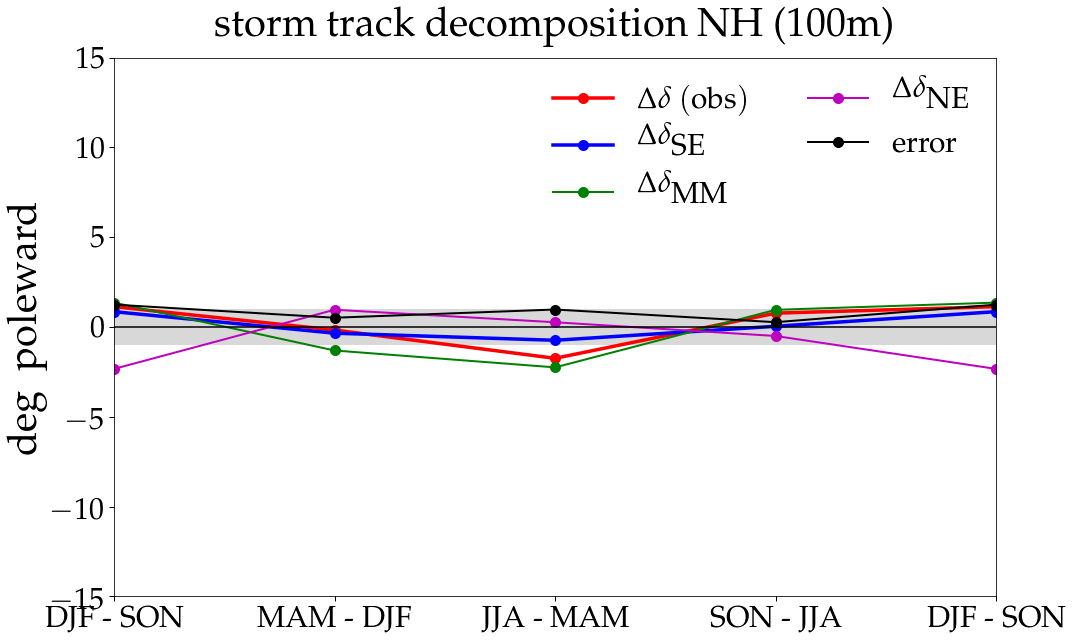

In [927]:
N=1; d=d+1; l=15;
plot_seasonal_shift_method2(N,d,l)

3


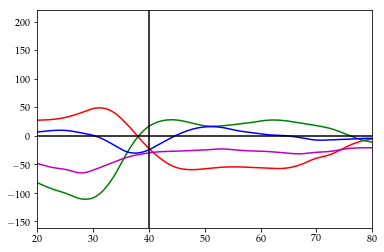

In [924]:
m=m+1

if m==3:
    
    py.plot(lat,TE_seas[d,:,0]-TE_seas[d,:,-1],'r-')
    py.plot(lat,MM_seas[d,:,0]-MM_seas[d,:,-1],'g-')
    py.plot(lat,SE_seas[d,:,0]-SE_seas[d,:,-1],'b-')
    py.plot(lat,NE_seas[d,:,0]-NE_seas[d,:,-1],'m-')
    print m    
    m=0
else :
    py.plot(lat,TE_seas[d,:,m+1]-TE_seas[d,:,m],'r-')
    py.plot(lat,MM_seas[d,:,m+1]-MM_seas[d,:,m],'g-')
    py.plot(lat,SE_seas[d,:,m+1]-SE_seas[d,:,m],'b-')
    py.plot(lat,NE_seas[d,:,m+1]-NE_seas[d,:,m],'m-')
    print m

py.xlim(20,80)
py.axvline(zero_div_TE[m],color='k')
py.axhline(0,color='k')


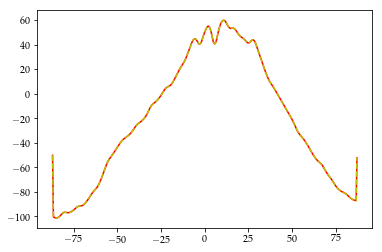

In [916]:
m=m+1
py.plot(lat,TE_seas[d,:,m]+SE_seas[d,:,m]+MM_seas[d,:,m],'r-')
py.plot(lat,NE_seas[d,:,m],'y--')

(4, 1741, 4)

In [522]:
def calculate_shift_just_by_adding_individual_flux_divergences():
    
    SE_change=np.zeros((4,len(lat),13))
    MM_change=np.zeros((4,len(lat),13))
    TE_change=np.zeros((4,len(lat),13))
    NE_change=np.zeros((4,len(lat),13))

    se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)
    
    div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
    div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
    div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
    div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)
    
    for month in range(0,12):

        del_div_SE1=div_se[:,:,month+1]-div_se[:,:,month]
        del_div_MM1=div_mm[:,:,month+1]-div_mm[:,:,month]
        del_div_TE1=div_te[:,:,month+1]-div_te[:,:,month]
        del_div_NE1=div_ne[:,:,month+1]-div_ne[:,:,month]
        
        SE_change[:,:,month+1]=te[:,:,month]-del_div_SE1
        MM_change[:,:,month+1]=te[:,:,month]-del_div_MM1
        TE_change[:,:,month+1]=te[:,:,month]+del_div_TE1
        NE_change[:,:,month+1]=te[:,:,month]+del_div_NE1

    SE_change[:,:,0]=SE_change[:,:,12]
    TE_change[:,:,0]=TE_change[:,:,12]
    MM_change[:,:,0]=MM_change[:,:,12]
    NE_change[:,:,0]=NE_change[:,:,12]
    return SE_change[...,:-1], MM_change[...,:-1], TE_change[...,:-1], NE_change[...,:-1]

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences()

In [523]:
# SE_change=np.zeros((4,len(lat),12))
# MM_change=np.zeros((4,len(lat),12))
# TE_change=np.zeros((4,len(lat),12))
# NE_change=np.zeros((4,len(lat),12))

# def calculate_changes_from_mean():
    
#     se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)
    
# #     div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
# #     div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
# #     div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
# #     div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)

#     for month in range(0,12):

#         del_div_SE1=se[:,:,month]-se.mean(axis=-1)
#         del_div_MM1=mm[:,:,month]-mm.mean(axis=-1)
#         del_div_TE1=te[:,:,month]-te.mean(axis=-1)
#         del_div_NE1=ne[:,:,month]-ne.mean(axis=-1)
        
#         SE_change[:,:,month]=te.mean(axis=-1)-del_div_SE1
#         MM_change[:,:,month]=te.mean(axis=-1)-del_div_MM1
#         TE_change[:,:,month]=te.mean(axis=-1)+del_div_TE1
#         NE_change[:,:,month]=te.mean(axis=-1)+del_div_NE1

#     return SE_change, MM_change, TE_change, NE_change

# SE_change, MM_change, TE_change, NE_change = calculate_changes_from_mean()

In [524]:
def separate_seasons(X,MO=3):
    season=np.zeros((4,len(lat),12/MO))
    Y=np.append(X[...,-1,None],X[...,:-1],axis=-1)
    for m in range(12):
        if m%MO==0:
            season[:,:,m/MO]=Y[:,:,m:m+MO].mean(axis=-1)
    return season

In [528]:
from scipy.interpolate import interp1d

def find_zero_seas(div,N=1,mean='no',MO=3):   
  if N==1 :
     l_range=((lat>=35) & (lat<=70))            
  if N==-1:
    l_range=((lat>=-70) & (lat<=-35))
  if mean == 'no' :
      zero_loc = np.zeros(12/MO)
      for m in range(0,12/MO): 
            if N==1 :
                interpolation_function = interp1d(div[l_range,m]      ,lat[l_range]      ,kind='linear')
            if N==-1 :
                interpolation_function = interp1d(div[l_range,m][::-1],lat[l_range][::-1],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan
  if mean == 'yes' :                   
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan                
  return zero_loc

In [534]:
from scipy.interpolate import interp1d
def plot_shift_from_mean_method2(N,d,l,MO=3) :
               
    if d==0: depth=5
    if d==1: depth=10
    if d==2: depth=50
    if d==3: depth=100
                
    SE_seas=separate_seasons(SE_change,MO)
    TE_seas=separate_seasons(TE_change,MO)
    MM_seas=separate_seasons(MM_change,MO)
    NE_seas=separate_seasons(NE_change,MO)

    zero_div_TE=find_zero_seas(TE_seas[d,...],N,'no',MO)
    zero_div_SE=find_zero_seas(SE_seas[d,...],N,'no',MO)
    zero_div_MM=find_zero_seas(MM_seas[d,...],N,'no',MO)
    zero_div_NE=find_zero_seas(NE_seas[d,...],N,'no',MO)
     
    mean_pos_TE=find_zero_seas(TE_seas[d,...].mean(axis=-1),N,mean='yes')
    
    print mean_pos_TE
    
#     if N==1 :
#         I=Intensity_teN
#     if N==-1 :
#         I=Intensity_teS
        
#     def threshold(I, pos1, pos2, pos3, pos4):
#         I=np.append(I[-1],I)
#         for m in range(13):
#             if (np.abs(I[m])<+1) :
#                 #N[d,m]=np.nan
#                 pos1[m]=np.nan
#                 pos2[m]=np.nan
#                 pos3[m]=np.nan
#                 pos4[m]=np.nan                
#         return pos1, pos2, pos3, pos4

#     zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
                
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1,y1[0])
        return y

    TE_obs         = add_month_to_end(zero_div_TE-mean_pos_TE)
    SE             = add_month_to_end(zero_div_SE-mean_pos_TE)
    MM             = add_month_to_end(zero_div_MM-mean_pos_TE)
    NE             = add_month_to_end(zero_div_NE-mean_pos_TE)
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\phi_{ ({obs})}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    #mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    mticks = ['D','J','F','M','A','M','J','J','A','S','O','N','D']
    #py.xlim(0,12)
 #   py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="stormtrack_shift_decomp_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    #py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
#     py.plot(range(12/MO+1),storm_pos_N[d,:]-mean_pos_TE)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

44.5832368526
         err   shiftEI    shiftMM    shiftSE  shiftTE_obs
0   2.164283 -2.027411  -4.009093  -0.681423    -4.553645
1   2.250054 -0.416900  -0.377296  -1.266493     0.189366
2  -2.944108  1.859409   1.965069   2.058775     2.939145
3 -16.832242  2.890546  12.812484  10.198484     9.069271
4   2.164283 -2.027411  -4.009093  -0.681423    -4.553645


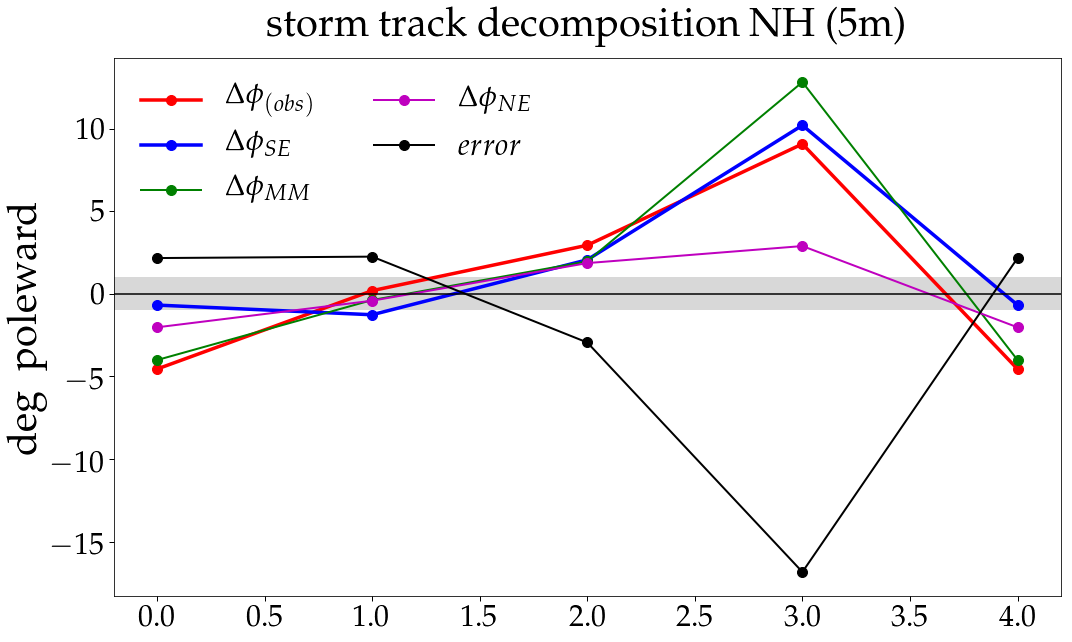

In [536]:
N=1;d=0;l=-15.5;MO=3
plot_shift_from_mean_method2(N,d,l,MO)